# DSCI 303 Final Progress Report
**by Ari Vilker, Min Kang**

## EDA and Data Pre-Processing

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import time
import numpy as np
from sklearn.svm import SVR
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

In [2]:
# Load data and display the data head

"""
pd.read_csv('https://github.com/nflverse/nflfastR-data/blob/master/data/play_by_play_' + str(i) + '.csv.gz?raw=True',
                         compression='gzip', low_memory=False)
"""

df0 = pd.read_csv('https://github.com/nflverse/nflfastR-data/blob/master/data/play_by_play_2018.csv.gz?raw=True',
                         compression='gzip', low_memory=False)
df0.head()

play_id          game_id  old_game_id home_team away_team season_type  \
0        1  2018_01_ATL_PHI   2018090600       PHI       ATL         REG   
1       37  2018_01_ATL_PHI   2018090600       PHI       ATL         REG   
2       52  2018_01_ATL_PHI   2018090600       PHI       ATL         REG   
3       75  2018_01_ATL_PHI   2018090600       PHI       ATL         REG   
4      104  2018_01_ATL_PHI   2018090600       PHI       ATL         REG   

   week posteam posteam_type defteam  ... out_of_bounds  home_opening_kickoff  \
0     1     NaN          NaN     NaN  ...             0                     0   
1     1     ATL         away     PHI  ...             0                     0   
2     1     ATL         away     PHI  ...             0                     0   
3     1     ATL         away     PHI  ...             1                     0   
4     1     ATL         away     PHI  ...             1                     0   

     qb_epa  xyac_epa  xyac_mean_yardage  xyac_median_yardage xyac_success  \
0       NaN       NaN                NaN                  NaN          NaN   
1 -0.000000       NaN                NaN                  NaN          NaN   
2 -0.773778       NaN                NaN                  NaN          NaN   
3  0.850118  0.564953           3.515878                  2.0     0.998706   
4  1.005722       NaN                NaN                  NaN          NaN   

    xyac_fd     xpass    pass_oe  
0       NaN       NaN        NaN  
1       NaN       NaN        NaN  
2       NaN  0.479781        NaN  
3  0.147457  0.587117  41.288257  
4       NaN  0.498259 -49.825913  

[5 rows x 372 columns]

#### Preparations

First, let's import the necessary libraries and load the data files for our example EDA. Our mission is to predict house SalePrice accurately using features. Differ from the housing price dataset you have worked on before, we will use a housing price dataset with more features in this exercise.

In [3]:
# Print the high-level information
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47874 entries, 0 to 47873
Columns: 372 entries, play_id to pass_oe
dtypes: float64(187), int64(38), object(147)
memory usage: 135.9+ MB


We can see in this data, not every features column has complete entries, which means: we have MISSING DATA!

From the information, we can already see that some features won't be relevant in our exploratory analysis or predictive modeling as there are too many missing values. Plus there are so many features to analyze that it may be better to concentrate on the ones which can give us real insights. Let's just remove Id and the features with 45% or more NaN values.

In [4]:
# Remove columns with too many missing values
df2 = df0[[column for column in df0 if df0[column].count() / len(df0) >= 0.55]]
df2.head()
del df2['play_id']
del df2['game_id']
del df2['old_game_id']
print("List of dropped columns:", end=" ")
for c in df0.columns:
    if c not in df2.columns:
        print(c, end=", ")
print('\n')
df = df2
df.head()

List of dropped columns: play_id, game_id, old_game_id, pass_length, pass_location, air_yards, yards_after_catch, run_location, run_gap, field_goal_result, kick_distance, extra_point_result, two_point_conv_result, timeout_team, td_team, td_player_name, td_player_id, air_epa, yac_epa, air_wpa, yac_wpa, passer_player_id, passer_player_name, passing_yards, receiver_player_id, receiver_player_name, receiving_yards, rusher_player_id, rusher_player_name, rushing_yards, lateral_receiver_player_id, lateral_receiver_player_name, lateral_receiving_yards, lateral_rusher_player_id, lateral_rusher_player_name, lateral_rushing_yards, lateral_sack_player_id, lateral_sack_player_name, interception_player_id, interception_player_name, lateral_interception_player_id, lateral_interception_player_name, punt_returner_player_id, punt_returner_player_name, lateral_punt_returner_player_id, lateral_punt_returner_player_name, kickoff_returner_player_name, kickoff_returner_player_id, lateral_kickoff_returner_pla

home_team away_team season_type  week posteam posteam_type defteam  \
0       PHI       ATL         REG     1     NaN          NaN     NaN   
1       PHI       ATL         REG     1     ATL         away     PHI   
2       PHI       ATL         REG     1     ATL         away     PHI   
3       PHI       ATL         REG     1     ATL         away     PHI   
4       PHI       ATL         REG     1     ATL         away     PHI   

  side_of_field  yardline_100   game_date  ...          id  \
0           NaN           NaN  2018-09-06  ...         NaN   
1           PHI          35.0  2018-09-06  ...         NaN   
2           ATL          75.0  2018-09-06  ...         NaN   
3           ATL          80.0  2018-09-06  ...  00-0026143   
4           ATL          70.0  2018-09-06  ...  00-0027944   

   fantasy_player_name  fantasy_player_id  fantasy  fantasy_id  out_of_bounds  \
0                  NaN                NaN      NaN         NaN              0   
1                  NaN                NaN      NaN         NaN              0   
2                  NaN                NaN      NaN         NaN              0   
3              J.Jones         00-0027944  J.Jones  00-0027944              1   
4              J.Jones         00-0027944  J.Jones  00-0027944              1   

   home_opening_kickoff    qb_epa     xpass    pass_oe  
0                     0       NaN       NaN        NaN  
1                     0 -0.000000       NaN        NaN  
2                     0 -0.773778  0.479781        NaN  
3                     0  0.850118  0.587117  41.288257  
4                     0  1.005722  0.498259 -49.825913  

[5 rows x 224 columns]

#### Distribution Analysis

Now, let's look into the distribution of the Drive Result.

In [5]:
print(df['fixed_drive_result'].describe())
plt.figure(figsize=(15, 8))
############################## write your code ###########################
# TODO: Plot the distribution of housing price (SalePrice)
df['fixed_drive_result'].hist()
plt.xlabel('fixed_drive_result')
plt.ylabel('Frequency')
plt.show()

count     47872
unique        9
top        Punt
freq      15337
Name: fixed_drive_result, dtype: object


In [6]:
df['fixed_drive_result_num'] = np.zeros(len(df))
for i in range(len(df['fixed_drive_result_num'])):
    result = df['fixed_drive_result'][i]
    if result == 'Turnover on downs':
        df['fixed_drive_result_num'][i] = 0
    if result == 'Punt':
        df['fixed_drive_result_num'][i] = 0
    if result == 'Field goal':
        df['fixed_drive_result_num'][i] = 3
    if result == 'End of half':
        df['fixed_drive_result_num'][i] = 0
    if result == 'Touchdown':
        df['fixed_drive_result_num'][i] = 6.952045
    if result == 'Turnover':
        df['fixed_drive_result_num'][i] = 0
    if result == 'Missed field goal':
        df['fixed_drive_result_num'][i] = 0
    if result == 'Opp touchdown':
        df['fixed_drive_result_num'][i] = -6.952045
    if result == 'Safety':
        df['fixed_drive_result_num'][i] = -2

C:\Users\minsu\AppData\Local\Temp/ipykernel_31944/2209791483.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fixed_drive_result_num'] = np.zeros(len(df))
C:\Users\minsu\AppData\Local\Temp/ipykernel_31944/2209791483.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fixed_drive_result_num'][i] = 0
C:\Users\minsu\AppData\Local\Temp/ipykernel_31944/2209791483.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

In [7]:
print('Expected Value of Drive (points): '+str(sum(df['fixed_drive_result_num'])/len(df)))

Expected Value of Drive (points): 2.465781938212515


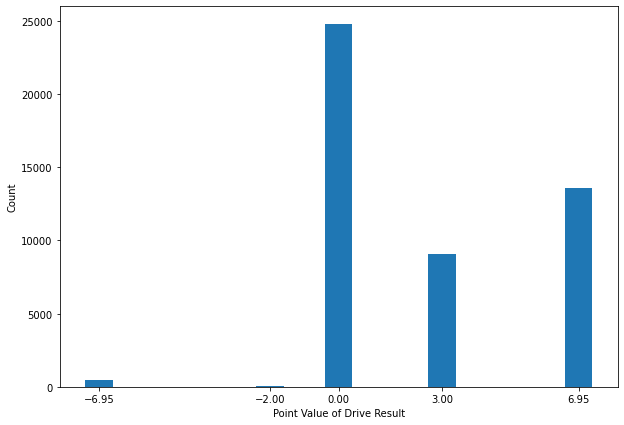

In [8]:
plt.figure(figsize=(10, 7))
arr = df['fixed_drive_result_num'].values
labels, counts = np.unique(arr, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.xlabel('Point Value of Drive Result')
plt.ylabel('Count')
plt.show()

We can plot the distribution for featrues as well, but note that the histogram can only take the numerical ones:

In [9]:
# Select the numerical featrues
df_num = df.select_dtypes(include = 'number')
df_num.head()

week  yardline_100  quarter_seconds_remaining  half_seconds_remaining  \
0     1           NaN                      900.0                  1800.0   
1     1          35.0                      900.0                  1800.0   
2     1          75.0                      900.0                  1800.0   
3     1          80.0                      900.0                  1800.0   
4     1          70.0                      862.0                  1762.0   

   game_seconds_remaining  quarter_end  drive  sp  qtr  down  ...  first_down  \
0                  3600.0            0    NaN   0    1   NaN  ...         NaN   
1                  3600.0            0    1.0   0    1   NaN  ...         0.0   
2                  3600.0            0    1.0   0    1   1.0  ...         0.0   
3                  3600.0            0    1.0   0    1   1.0  ...         0.0   
4                  3562.0            0    1.0   0    1   2.0  ...         1.0   

   special  play  jersey_number  out_of_bounds  home_opening_kickoff  \
0        0     0            NaN              0                     0   
1        1     0            NaN              0                     0   
2        0     1            NaN              0                     0   
3        0     1            2.0              1                     0   
4        0     1           11.0              1                     0   

     qb_epa     xpass    pass_oe  fixed_drive_result_num  
0       NaN       NaN        NaN                     0.0  
1 -0.000000       NaN        NaN                     0.0  
2 -0.773778  0.479781        NaN                     0.0  
3  0.850118  0.587117  41.288257                     0.0  
4  1.005722  0.498259 -49.825913                     0.0  

[5 rows x 183 columns]

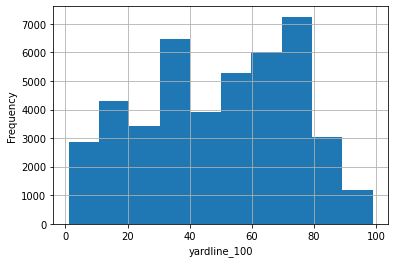

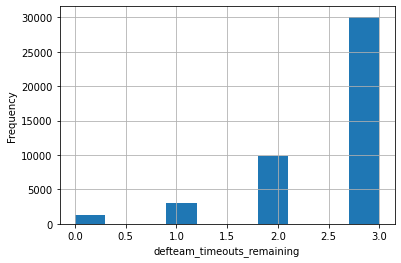

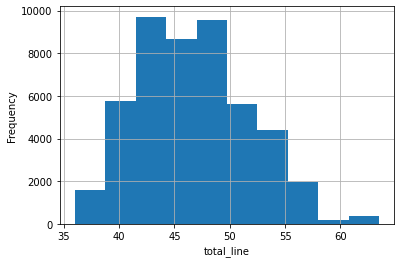

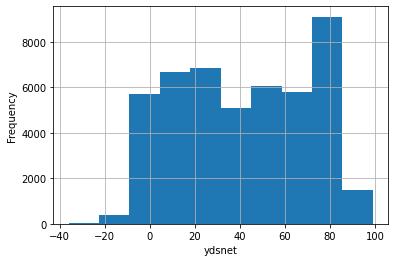

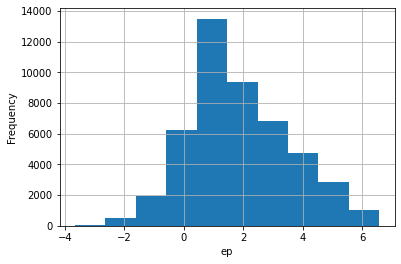

In [10]:
mycols = ['yardline_100','half_seconds_remaining','down','ydstogo','defteam_timeouts_remaining','total_line','ydsnet','ep']
for col in mycols:
    df[col].hist()
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [11]:
df_cate = df.select_dtypes(include = ['O'])
print('There is {} non numerical features including:\n{}'.format(len(df_cate.columns), df_cate.columns.tolist()))

There is 42 non numerical features including:
['home_team', 'away_team', 'season_type', 'posteam', 'posteam_type', 'defteam', 'side_of_field', 'game_date', 'game_half', 'time', 'yrdln', 'desc', 'play_type', 'series_result', 'start_time', 'time_of_day', 'stadium', 'weather', 'nfl_api_id', 'play_type_nfl', 'end_yard_line', 'fixed_drive_result', 'drive_time_of_possession', 'drive_start_transition', 'drive_end_transition', 'drive_game_clock_start', 'drive_game_clock_end', 'drive_start_yard_line', 'drive_end_yard_line', 'location', 'roof', 'surface', 'home_coach', 'away_coach', 'stadium_id', 'game_stadium', 'name', 'id', 'fantasy_player_name', 'fantasy_player_id', 'fantasy', 'fantasy_id']


Looking at these features, we can see that a lot of them are of the type `Object(O)`. Using  [Pandas categorical functions](http://pandas.pydata.org/pandas-docs/stable/categorical.html) (equivalent to R's factor) will help shape our data in a way that would be interpretable for our machine learning algorithm.

## Correlation Analysis

### Correlation Coefficient Calculation

Let's visualize the correlations among columns using heatmap!

In [13]:
df_corr0 = df_num.corr()
plt.figure(figsize=(60, 60))

sns.heatmap(df_corr0, 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

### Filter on Correlation Coefficient

Now we'll try to find which features are strongly correlated with Expected Drive Result. We'll store them in a list called golden_features_list. We'll reuse our df_num dataset to do so.

In [14]:
############################## write your code ###########################
# TODO: get the correlation between features and label (SalePrice)
# Only last column or last row of the correlation matrix above is needed as we want to focus on the label
df_corr = df_corr0['fixed_drive_result_num']
golden_features_list = df_corr[abs(df_corr) > 0.01].sort_values(ascending=False)
print("There is {} strongly correlated values with Drive Result:\n{}".format(len(golden_features_list), golden_features_list))
golden_features_list = golden_features_list[1:]

There is 146 strongly correlated values with Drive Result:
fixed_drive_result_num    1.000000
drive_ended_with_score    0.878387
ydsnet                    0.732502
drive_first_downs         0.683010
drive_inside20            0.647916
                            ...   
no_score_prob            -0.181350
punt_attempt             -0.186513
opp_td_prob              -0.285036
opp_fg_prob              -0.303523
yardline_100             -0.400779
Name: fixed_drive_result_num, Length: 146, dtype: float64


### Correlation Analysis Significance

All features with |r| > 0.01 yield statistically significant p value (p < 0.05). Most have low p value (p < 0.001)

In [15]:
from scipy.stats import pearsonr

golden_features_sig = []
badct = 0
print("Statistically insignificant correlation coefficient by features (p > 0.001)")
for i in range(len(golden_features_list)):
    myfeature = list(golden_features_list.index)[i]
    df_clean = df[[myfeature, 'fixed_drive_result_num']].dropna()
    rsigval = pearsonr(df_clean[myfeature], df_clean['fixed_drive_result_num'])
    if rsigval[1] >= 0.001:
        print(myfeature+'\t'+str(rsigval[1]))
        badct = badct+1
    golden_features_sig.append(rsigval)
if badct == 0:
    print('None')

Statistically insignificant correlation coefficient by features (p > 0.001)
home_wp_post	0.0025620342069773215
result	0.0022340316913188173
qb_dropback	0.004026815332656265
qb_scramble	0.0036993853368680273
home_wp	0.00625839128680509
spread_line	0.006959806886441053
total_home_comp_air_epa	0.009341739820356904
lateral_rush	0.013842165877070385
total_home_score	0.015630245076664644
total_home_pass_wpa	0.02349758064735003
total_away_pass_wpa	0.02349758064735003
div_game	0.016359717236709703
qb_spike	0.010303276555168224
total_away_comp_air_epa	0.009341739820356904
away_wp	0.00625839128680509
away_wp_post	0.00303610089492061
timeout	0.0018514716161594296


### Correlation Analysis Feature Filtering

From our list of significant features of high magnitude of correlation (p < 0.001, |r| > 0.05), we found a couple of features that are usable. In other words, we have to eliminate features that are directly related or can be used to derive the expected drive value.

In [12]:
filtered_golden_features = ['total_line','down','yardline_100','away_timeouts_remaining','home_timeouts_remaining','half_seconds_remaining']

In [17]:
# Requires df_corr from above (no need to run again)
df_corr[filtered_golden_features]

total_line                 0.108619
down                      -0.175385
yardline_100              -0.400779
away_timeouts_remaining    0.060686
home_timeouts_remaining    0.050701
half_seconds_remaining     0.036399
Name: fixed_drive_result_num, dtype: float64

In [13]:
clean_features = filtered_golden_features.copy()
clean_features.append('fixed_drive_result_num')
clean_df0 = df[clean_features]
clean_df0.head(30)

total_line  down  yardline_100  away_timeouts_remaining  \
0         44.5   NaN           NaN                        3   
1         44.5   NaN          35.0                        3   
2         44.5   1.0          75.0                        3   
3         44.5   1.0          80.0                        3   
4         44.5   2.0          70.0                        3   
5         44.5   1.0          59.0                        3   
6         44.5   1.0          39.0                        3   
7         44.5   2.0          39.0                        3   
8         44.5   3.0          39.0                        3   
9         44.5   1.0           6.0                        3   
10        44.5   2.0           1.0                        3   
11        44.5   3.0           1.0                        3   
12        44.5   4.0           1.0                        3   
13        44.5   1.0          98.0                        3   
14        44.5   2.0          96.0                        3   
15        44.5   3.0          92.0                        3   
16        44.5   4.0          92.0                        3   
17        44.5   1.0          44.0                        3   
18        44.5   2.0          44.0                        3   
19        44.5   3.0          39.0                        3   
20        44.5   1.0          33.0                        3   
21        44.5   2.0          36.0                        3   
22        44.5   1.0          10.0                        3   
23        44.5   2.0           7.0                        3   
24        44.5   3.0           7.0                        3   
25        44.5   3.0           3.0                        3   
26        44.5   4.0           3.0                        3   
27        44.5   NaN          35.0                        3   
28        44.5   1.0          69.0                        3   
29        44.5   2.0          68.0                        3   

    home_timeouts_remaining  half_seconds_remaining  fixed_drive_result_num  
0                         3                  1800.0                     0.0  
1                         3                  1800.0                     0.0  
2                         3                  1800.0                     0.0  
3                         3                  1800.0                     0.0  
4                         3                  1762.0                     0.0  
5                         3                  1726.0                     0.0  
6                         3                  1690.0                     0.0  
7                         3                  1685.0                     0.0  
8                         3                  1681.0                     0.0  
9                         3                  1635.0                     0.0  
10                        3                  1601.0                     0.0  
11                        3                  1559.0                     0.0  
12                        3                  1555.0                     0.0  
13                        3                  1551.0                     0.0  
14                        3                  1510.0                     0.0  
15                        3                  1464.0                     0.0  
16                        3                  1460.0                     0.0  
17                        3                  1448.0                     3.0  
18                        3                  1442.0                     3.0  
19                        3                  1404.0                     3.0  
20                        3                  1358.0                     3.0  
21                        3                  1321.0                     3.0  
22                        3                  1279.0                     3.0  
23                        3                  1238.0                     3.0  
24                        3                  1232.0                     3.0  
25                    

## Data Final Cleanup

### Missing Data

We know that certain plays correspond to special situations like a kickoff, where you do not have a designated yard line at which the play starts. Other times we have an extra points attempt after a touchdown result. We can simply remove these points from consideration, since there is a lot of variance in where the kick ends up landing and how the other team returns the ball, and this information has not been thoroughly recorded in the data. It is better to just start predicting once there is a given field position.

In [14]:
clean_df = clean_df0.dropna()
clean_df

total_line  down  yardline_100  away_timeouts_remaining  \
2            44.5   1.0          75.0                        3   
3            44.5   1.0          80.0                        3   
4            44.5   2.0          70.0                        3   
5            44.5   1.0          59.0                        3   
6            44.5   1.0          39.0                        3   
...           ...   ...           ...                      ...   
47868        55.5   1.0          51.0                        1   
47869        55.5   2.0          51.0                        1   
47870        55.5   1.0          30.0                        1   
47871        55.5   2.0          30.0                        1   
47872        55.5   1.0          62.0                        1   

       home_timeouts_remaining  half_seconds_remaining  fixed_drive_result_num  
2                            3                  1800.0                     0.0  
3                            3                  1800.0                     0.0  
4                            3                  1762.0                     0.0  
5                            3                  1726.0                     0.0  
6                            3                  1690.0                     0.0  
...                        ...                     ...                     ...  
47868                        0                    25.0                     0.0  
47869                        0                    21.0                     0.0  
47870                        0                     9.0                     0.0  
47871                        0                     8.0                     0.0  
47872                        0                     5.0                     0.0  

[39521 rows x 7 columns]

In [15]:
clean_df.to_csv('nfl2018clean.csv')

## Model Building

We are now ready to build our regression models. We will start with a basic Linear Regression on our 6 predictors. We may have to revisit our feature selection process. We are also considering using stronger models such as nonlinear Regression methods.

## Splitting the train and test sets

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
dfx = clean_df.iloc[:,0:6]
dfy = clean_df.iloc[:,6]
X_train, X_test, y_train, y_test = train_test_split(dfx, dfy, test_size=0.25, random_state=42)
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

### Linear Regression Model with carefully selected features

Our basic linear regression model gets the drive value prediction wrong by an average of 2.2 points.

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import numpy as np

In [19]:
def average_error_rate(test, pred):
    diff = np.abs(test - pred)
    return np.divide(diff, test).mean()

In [20]:
ytrainreg = LinearRegression()
ytrainreg.fit(X_train, y_train)
y_pred_train = ytrainreg.predict(X_train)
y_pred_test = ytrainreg.predict(X_test)
print(ytrainreg.intercept_)
print(ytrainreg.coef_)

print("Training mean absolute error is: ", mean_absolute_error(y_train, y_pred_train))
print("Test mean absolute error is: ", mean_absolute_error(y_test, y_pred_test))
print()
print("Training RMSE is: ", mean_squared_error(y_train, y_pred_train, squared=False))
print("Test RMSE is: ", mean_squared_error(y_test, y_pred_test, squared=False))
print()
print("Training mean error rate is: ", average_error_rate(y_train, y_pred_train))
print("Test mean error rate is: ", average_error_rate(y_test, y_pred_test))

2.4104260180499324
[ 0.26795901 -0.57932089 -1.28016819  0.13326493  0.08968198  0.11059279]
Training mean absolute error is:  2.195906369162595
Test mean absolute error is:  2.2252583795133356

Training RMSE is:  2.7220525060567478
Test RMSE is:  2.749825898493322

Training mean error rate is:  inf
Test mean error rate is:  inf


### Polynomial Kernel Regression

In [26]:
from sklearn.model_selection import GridSearchCV

start = time.time()
print("Start GridSearch")

mygrid = {'C':[0.01,0.1,1,10]}

#mygrid = {'degree':[2,3,4],'C':[1,10,100,1000]}

clf = GridSearchCV(SVR(kernel="poly", degree=2, epsilon=0.1, gamma="scale"), param_grid = mygrid, n_jobs = 40, verbose = 3)
clf2 = clf.fit(X_train, y_train)
myparams = clf2.best_params_
print(myparams)

elapsed = time.time() - start
print(elapsed)

Start GridSearch
Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'C': 10}
348.5423047542572


In [23]:
Cvals = [1, 0.1, 0.01, 0.001]
for Cval in Cvals:
    startTime = time.time()
    print('Time start: C = ' + str(Cval))
    svm_poly_reg = SVR(kernel="poly", degree=2, C=Cval, epsilon=0.1, gamma="scale")
    poly2model = svm_poly_reg.fit(X_train, y_train)
    executionTime = (time.time() - startTime)
    y2pred = poly2model.predict(X_test)
    print('Execution time in seconds: ' + str(executionTime))
    print("Test mean absolute error is: ", mean_absolute_error(y_test, y2pred))
    print("Test RMSE is: ", mean_squared_error(y_test, y2pred, squared=False))

Time start: C = 1
Execution time in seconds: 36.96103644371033
Test mean absolute error is:  2.4124451021308775
Test RMSE is:  3.3105256103950866
Time start: C = 0.1
Execution time in seconds: 33.357537269592285
Test mean absolute error is:  2.41218234594344
Test RMSE is:  3.3151891335970363
Time start: C = 0.01
Execution time in seconds: 27.654289722442627
Test mean absolute error is:  2.424353357241833
Test RMSE is:  3.353575101198066
Time start: C = 0.001
Execution time in seconds: 27.75171661376953
Test mean absolute error is:  2.522954916826891
Test RMSE is:  3.725802985791355


In [25]:
Cvals = [100, 10]
for Cval in Cvals:
    startTime = time.time()
    print('Time start: C = ' + str(Cval))
    svm_poly_reg = SVR(kernel="poly", degree=2, C=Cval, epsilon=0.1, gamma="scale")
    poly2model = svm_poly_reg.fit(X_train, y_train)
    executionTime = (time.time() - startTime)
    y2pred = poly2model.predict(X_test)
    print('Execution time in seconds: ' + str(executionTime))
    print("Test mean absolute error is: ", mean_absolute_error(y_test, y2pred))
    print("Test RMSE is: ", mean_squared_error(y_test, y2pred, squared=False))

Time start: C = 100
Execution time in seconds: 220.38442635536194
Test mean absolute error is:  2.412462697302739
Test RMSE is:  3.3101790582724804
Time start: C = 10
Execution time in seconds: 53.10366106033325
Test mean absolute error is:  2.412468003409417
Test RMSE is:  3.3102821303625003


Run time takes hours for anything past p = 4 kernel.

In [27]:
degrees = [2,4]
polypredicts = []
for deg in degrees:
    startTime = time.time()
    print('Time start: deg = ' + str(deg))
    svm_poly_reg = SVR(kernel="poly", degree=deg, C=10, epsilon=0.1, gamma="scale")
    polymodel = svm_poly_reg.fit(X_train, y_train)
    ypolypred = polymodel.predict(X_test)
    polypredicts.append(ypolypred)
    executionTime = (time.time() - startTime)
    print('Execution time in seconds: ' + str(executionTime))
    print("Test mean absolute error is: ", mean_absolute_error(y_test, ypolypred))
    print("Test RMSE is: ", mean_squared_error(y_test, ypolypred, squared=False))

Time start: deg = 2
Execution time in seconds: 61.608622550964355
Test mean absolute error is:  2.412468003409417
Test RMSE is:  3.3102821303625003
Time start: deg = 4
Execution time in seconds: 192.8843870162964
Test mean absolute error is:  2.311971370331562
Test RMSE is:  3.315726075197975


### RBF Kernel Regression

In [17]:
from sklearn.model_selection import GridSearchCV

start = time.time()
print("Start GridSearch")

mygrid = {'C':[1,10,100]}


clf = GridSearchCV(SVR(kernel="rbf", epsilon=0.1, gamma="scale"), param_grid = mygrid, n_jobs = 40, verbose = 3)
clf2_rbf = clf.fit(X_train, y_train)
myparams_rbf = clf2_rbf.best_params_
print(myparams_rbf)

elapsed = time.time() - start
print(elapsed)

Start GridSearch
Fitting 5 folds for each of 3 candidates, totalling 15 fits
{'C': 100}
511.3831853866577


In [23]:
Cvals = [0.01,0.1]
for Cval in Cvals:
    startTime = time.time()
    print('Time start: C = ' + str(Cval))
    svm_poly_reg = SVR(kernel="rbf", C=Cval, epsilon=0.1, gamma="scale")
    poly2model = svm_poly_reg.fit(X_train, y_train)
    executionTime = (time.time() - startTime)
    y2pred = poly2model.predict(X_test)
    print('Execution time in seconds: ' + str(executionTime))
    print("Test mean absolute error is: ", mean_absolute_error(y_test, y2pred))
    print("Test RMSE is: ", mean_squared_error(y_test, y2pred, squared=False))

Time start: C = 0.01
Execution time in seconds: 31.1756591796875
Test mean absolute error is:  2.0303699645136586
Test RMSE is:  2.9422802679966114
Time start: C = 0.1
Execution time in seconds: 30.321208238601685
Test mean absolute error is:  1.9523416105849445
Test RMSE is:  2.9423980892721637


In [22]:
Cvals = [1,10]
for Cval in Cvals:
    startTime = time.time()
    print('Time start: C = ' + str(Cval))
    svm_poly_reg = SVR(kernel="rbf", C=Cval, epsilon=0.1, gamma="scale")
    poly2model = svm_poly_reg.fit(X_train, y_train)
    executionTime = (time.time() - startTime)
    y2pred = poly2model.predict(X_test)
    print('Execution time in seconds: ' + str(executionTime))
    print("Test mean absolute error is: ", mean_absolute_error(y_test, y2pred))
    print("Test RMSE is: ", mean_squared_error(y_test, y2pred, squared=False))

Time start: C = 1
Execution time in seconds: 33.91925120353699
Test mean absolute error is:  1.931680721781785
Test RMSE is:  2.9614131570663815
Time start: C = 10
Execution time in seconds: 47.65255522727966
Test mean absolute error is:  1.9246451064751797
Test RMSE is:  2.9581625330207673


In [21]:
Cvals = [100]
for Cval in Cvals:
    startTime = time.time()
    print('Time start: C = ' + str(Cval))
    svm_poly_reg = SVR(kernel="rbf", C=Cval, epsilon=0.1, gamma="scale")
    poly2model = svm_poly_reg.fit(X_train, y_train)
    executionTime = (time.time() - startTime)
    y2pred = poly2model.predict(X_test)
    print('Execution time in seconds: ' + str(executionTime))
    print("Test mean absolute error is: ", mean_absolute_error(y_test, y2pred))
    print("Test RMSE is: ", mean_squared_error(y_test, y2pred, squared=False))

Time start: C = 100
Execution time in seconds: 198.0478491783142
Test mean absolute error is:  1.9270169410142801
Test RMSE is:  2.958692281993337


### Linear Regression Model with all high correlation features

We just want to see what happens when you include all the features of high correlation, even when they may directly affect the point outcome. We can achieve MAE of about 0.8 points, which is better than the 2.2 points from above.

In [21]:
bigdfx = df_num.copy().dropna()
bigdfy = bigdfx['fixed_drive_result_num']
bigdfx = bigdfx.iloc[:,0:-1]
X_train, X_test, y_train, y_test = train_test_split(bigdfx, bigdfy, test_size=0.25, random_state=42)
X_train_w_label = df_num.copy().dropna()

############################## write your code ###########################
# TODO: get golden_features_list with a correlation
# threshold of 0.05 using the method we've developed in EDA part
df_corr5 = X_train_w_label.corr()['fixed_drive_result_num']
golden_features_list = df_corr5[abs(df_corr5) > 0.05].sort_values(ascending=False)
golden_features_list = golden_features_list[1:]

In [22]:
X_test[golden_features_list.index]

drive_ended_with_score  ydsnet  drive_first_downs  drive_inside20  \
39944                     0.0    -3.0                0.0             0.0   
6582                      0.0    61.0                4.0             1.0   
16137                     0.0     8.0                0.0             0.0   
23907                     0.0     4.0                0.0             0.0   
314                       0.0    -7.0                0.0             0.0   
...                       ...     ...                ...             ...   
16727                     0.0    -5.0                0.0             0.0   
5380                      1.0    43.0                3.0             0.0   
26273                     1.0    57.0                4.0             1.0   
8724                      0.0    32.0                2.0             0.0   
7191                      1.0    60.0                2.0             0.0   

       series_success        ep  drive_play_count   td_prob       epa  \
39944               0  2.263640               3.0  0.456096 -0.429085   
6582                1  0.736383               8.0  0.242399 -0.462043   
16137               0  1.476790               2.0  0.406733  0.616561   
23907               0  0.464045               3.0  0.317732 -0.438542   
314                 0  0.964353               3.0  0.380262 -0.521428   
...               ...       ...               ...       ...       ...   
16727               0 -0.075786               3.0  0.179949 -1.122265   
5380                1  2.713478               9.0  0.459505  0.327361   
26273               1  2.264970              11.0  0.080932  0.519399   
8724                1  0.959625               8.0  0.364350  1.334814   
7191                1  2.165613               3.0  0.435188  1.319911   

         qb_epa  ...  interception  return_touchdown  ydstogo  safety_prob  \
39944 -0.429085  ...           0.0               0.0       10     0.004177   
6582  -0.462043  ...           0.0               0.0       10     0.001280   
16137  0.616561  ...           0.0               0.0       10     0.003670   
23907 -0.438542  ...           0.0               0.0       10     0.002969   
314   -0.521428  ...           0.0               0.0       11     0.003143   
...         ...  ...           ...               ...      ...          ...   
16727 -1.122265  ...           0.0               0.0       10     0.003614   
5380   0.327361  ...           0.0               0.0        3     0.001907   
26273  0.519399  ...           0.0               0.0       11     0.000336   
8724   1.334814  ...           0.0               0.0        2     0.004099   
7191   1.319911  ...           0.0               0.0       10     0.002021   

       opp_safety_prob  no_score_prob  third_down_failed  opp_td_prob  \
39944         0.001687       0.006617                0.0     0.186778   
6582          0.002128       0.357420                0.0     0.150685   
16137         0.001983       0.004660                0.0     0.226042   
23907         0.001915       0.037664                0.0     0.282934   
314           0.002546       0.009107                0.0     0.256765   
...                ...            ...                ...          ...   
16727         0.001780       0.341680                1.0     0.194326   
5380          0.001568       0.039219                0.0     0.141777   
26273         0.000283       0.315581                0.0     0.007590   
8724          0.001967       0.022210                0.0     0.257349   
7191          0.002302       0.019528                0.0     0.186357   

       opp_fg_prob  yardline_100  
39944     0.110084          62.0  
6582      0.107030          80.0  
16137     0.143693          75.0  
23907     0.142002          75.0  
314       0.157642          71.0  
...            ...           ...  
16727     0.135795          75.0  
5380      0.096562          50.0  
26273     0.005727          31.0  
8724      0.140620          62.0  
7191      0.106576

In [23]:
model_selected_features = LinearRegression()

model_selected_features.fit(X_train[golden_features_list.index], y_train)
y_pred_train_ = model_selected_features.predict(X_train[golden_features_list.index])
y_pred_test_ = model_selected_features.predict(X_test[golden_features_list.index])
print("Training mean absolute error is: ", mean_absolute_error(y_train, y_pred_train_))
print("Test mean absolute error is: ", mean_absolute_error(y_test, y_pred_test_))
print()
print("Training RMSE is: ", mean_squared_error(y_train, y_pred_train_, squared=False))
print("Test RMSE is: ", mean_squared_error(y_test, y_pred_test_, squared=False))
print()
print("Training mean error rate is: ", average_error_rate(y_train, y_pred_train_))
print("Test mean error rate is: ", average_error_rate(y_test, y_pred_test_))

Training mean absolute error is:  0.7613425851501939
Test mean absolute error is:  0.7775332289204048

Training RMSE is:  1.0830859153700385
Test RMSE is:  1.115344535067419

Training mean error rate is:  inf
Test mean error rate is:  inf
